In [1]:
%matplotlib inline

# Normal modules
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import StratifiedShuffleSplit

# Torch modules
import torch
from torch import nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms

# Own codes written for this tutorial
from codes import train_utils
from codes import val_utils
from codes.augmentations import *
from codes.dataset import InvasiveSpeciesDataset

## Exploration

In [2]:
metadata = pd.read_csv('data/train_labels.csv')
metadata.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [3]:
SEED = 42
LR = 1e-2
BS = 16
DATSET_LOC = 'data/train/'

In [4]:
resize = (350,350)


fname = str(metadata.name.loc[2]) + '.jpg'
fname = os.path.join(DATSET_LOC, fname)

img = cv2.imread(fname)
img = cv2.resize(img, resize)
img_inv = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


fname = str(metadata.name.loc[0]) + '.jpg'
fname = os.path.join(DATSET_LOC, fname)

img = cv2.imread(fname)
img = cv2.resize(img, resize)
img_none = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

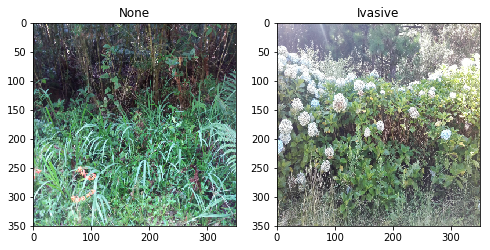

In [7]:
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.title('None')
plt.imshow(img_none)
plt.subplot(122)
plt.title('Ivasive')
plt.imshow(img_inv)
plt.show()

### Splits

In [8]:
sss = StratifiedShuffleSplit(2, train_size=0.8, random_state=SEED)
train_index, test_index = next(sss.split(metadata['name'], metadata['invasive']))

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1639: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
X_train = metadata.iloc[train_index]
X_val = metadata.iloc[test_index]

### Augmentations and transforms

In [10]:
train_transforms  = transforms.Compose([
    lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB),
    lambda x: cv2.resize(x, (350, 350)),
    lambda x: augment_random_linear(x, sr=10, ssx=0.2, ssy=0.2),
    lambda x: augment_random_crop(x, (320, 320)),
    lambda x: augment_random_flip(x, hprob=0.5, vprob=0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms  = transforms.Compose([
    lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB),
    lambda x: cv2.resize(x, (350, 350)),
    lambda x: center_crop(x, (320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
train_ds = InvasiveSpeciesDataset(DATSET_LOC, X_train, train_transforms)
train_loader = data.DataLoader(train_ds, BS, shuffle=True, drop_last=True)

val_ds = InvasiveSpeciesDataset(DATSET_LOC, X_val, val_transforms)
val_loader = data.DataLoader(val_ds, BS, shuffle=True, drop_last=True)

In [29]:
class SqueezeFineTune(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = models.squeezenet1_1(pretrained=True).features
        self.classifier = nn.Sequential(nn.Dropout(0.5),
                                        nn.Linear(512,1)
                                       )
    def forward(self, x):
        o = self.features(x)
        o = F.adaptive_avg_pool2d(o, 1)
        o = o.view(o.size(0), -1)
        o = self.classifier(o)
        return o

In [30]:
net = SqueezeFineTune()
net(Variable(train_transforms(img).unsqueeze(0)))

Variable containing:
-0.5212
[torch.FloatTensor of size 1x1]

In [13]:
torch.__version__

'0.3.1'